# Import Libraries and define global variables

In [1]:
import numpy as np
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
import os
import time
from tqdm.notebook import tqdm

device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float
torch.cuda.empty_cache()

# Environment Wrapper

In [2]:
class Atari_Wrapper(gym.Wrapper):
    # env wrapper to resize images, grey scale and frame stacking and other misc.
    
    def __init__(self, env, env_name, k, L, dsize=(80,80), use_add_done=False):
        super(Atari_Wrapper, self).__init__(env)
        self.dsize = dsize
        self.k = k
        self.L = L
        self.use_add_done = use_add_done
        self.gs = transforms.Grayscale()
        self.rs = transforms.Resize(dsize)
        
        # set image cutout depending on game
        if "SpaceInvaders" in env_name:
            self.frame_cutout_h = (25,-7)
            self.frame_cutout_w = (7,-7)
        else:
            # no cutout
            self.frame_cutout_h = (0,-1)
            self.frame_cutout_w = (0,-1)
        
    def reset(self):
    
        self.Return = 0
        self.last_life_count = 0
        
        ob, _ = self.env.reset() #here it calls the default version of the reset function
        ob = self.preprocess_observation(ob) #now ob is ready to be feed in the network

        
        # create L stacks of the reset observation
        self.frame_stack_list = [] #reset the frame list; it will be of size self.L
        frame_stack = torch.stack([ob for j in range(self.k)])
        #To parallelize the process create a single stack of the entire sequence
        self.frame_stack_sequence = torch.stack([frame_stack for i in range(self.L)])

        return self.frame_stack_sequence #returns a stack of the entire sequence
    
    
    def step(self, action): 
        
        reward = 0
        done = False
        additional_done = False
        
        # k frame skips or end of episode
        frames = []
        stacks = []
        tot_frames = self.L * 2
        for i in range(tot_frames):
            # build observation during the step in order to reduce the computational cost
            
            ob, r, d, _, info = self.env.step(action) #I think here it calls the default version of the step function #1 step
            
            # insert a (additional) done, when agent loses a life (Games with lives)
            if self.use_add_done:
                if info['lives'] < self.last_life_count:
                    additional_done = True  
                self.last_life_count = info['lives']
            
            processed_ob = self.preprocess_observation(ob) #prepare frames to be feed into the network (into device)
            frames.append(processed_ob)

            if (i+1)%self.k==0: #collected enough frames
                frame_stack = torch.stack(frames)
                stacks.append(frame_stack)
                frames = [] #reset the frames list
            
            # add reward
            reward += r
            
            if d: # env done
                done = True
                break
                       
        # build the observation
        num_frames = len(frames) #max is k, but then is reset, so check for 0
        num_stacks = len(stacks) #max is L
        # The episode can end prematurely and we have to consider these cases. There are 3:
        # 1st: len(frames)==0, but i<tot_frames; in this case we have a slot of n stacks that we can add to an existing frame_stack_sequence
        if num_frames==0 and (i+1)!=tot_frames:
            front = self.frame_stack_sequence[num_stacks::]   # /or/ self.frame_stack_sequence[0: self.L - num_stacks] = self.frame_stack_sequence[num_stacks::]
            curr_stack_seq = torch.stack(stacks)
            self.frame_stack_sequence = torch.cat([front, curr_stack_seq])    # /or/ self.frame_stack[self.L - num_stacks::] =  curr_stack_seq
        # 2nd: len(frames)>0 for the last stack; in this case we have to mask the remaing elements to fill the last stack
        elif num_frames>0 and (i+1)==tot_frames:
            mask_tensor = torch.zeros_like(processed_ob)
            #create the last stack
            for i in range(self.k-num_frames):
                frames.append(mask_tensor)
            last_stack = torch.stack(frames)
            # adding last stack to the list of stacks and create the sequence
            stacks.append(last_stack)
            self.frame_stack_sequence = torch.stack(stacks)
        # 3rd: len(frames)>0 and i<tot_frames; in this case we have to do both
        elif num_frames>0 and (i+1)!=tot_frames: #episode ended before collecting all the frames, this happen when the stack exists yet
            # move the last frames of the old sequence to the front=0
            front = self.frame_stack_sequence[num_stacks::]
            #create the last stack
            mask_tensor = torch.zeros_like(processed_ob)
            for i in range(self.k-num_frames):
                frames.append(mask_tensor)
            last_stack = torch.stack(frames)
            # adding last stack to the list of stacks and create the sequence
            stacks.append(last_stack)
            curr_stack_seq = torch.stack(stacks)
            self.frame_stack_sequence = torch.cat([front, curr_stack_seq])
        else: #episode end without any problem, so we just create a new stack sequence
            self.frame_stack_sequence = torch.stack(stacks)
        
        # add info, get return of the completed episode
        self.Return += reward
        if done:
            info["return"] = self.Return
            
        return self.frame_stack_sequence, reward, done, additional_done, info

    def preprocess_observation(self, ob):
    # resize and grey and cutout image

        # to tensor
        ob = ob[self.frame_cutout_h[0]:self.frame_cutout_h[1], self.frame_cutout_w[0]:self.frame_cutout_w[1]].transpose(2,0,1) #Torch wants images in format (channels, height, width) 
        ob = torch.from_numpy(ob) #maybe torch.tensor(ob) is enough
        #reduce channel from 3 to 1
        ob = self.gs(ob)
        #reduce image size to the specified one (84x84)
        ob = self.rs(ob)
        #transfer to gpu and change type
        ob = ob.view(-1,ob.size(2)).to(device).to(dtype)
        #normalize
        ob = ob/255
    
        return ob

# Network

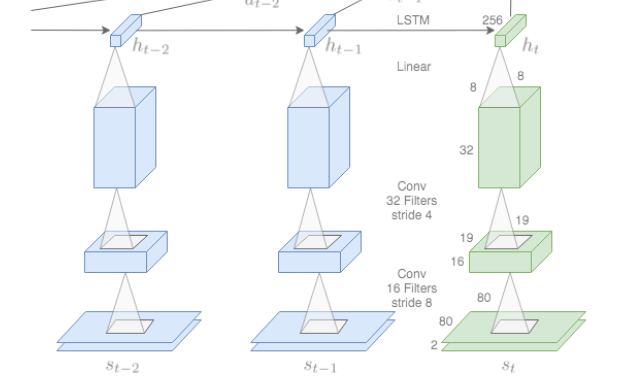

In [3]:
class MyCNN(nn.Module):

    def __init__(self, n_frames, hidden_size=16):
        super().__init__()
        # changing the shape of the network
        self.conv1 = nn.Conv2d(n_frames, hidden_size, kernel_size=19, stride=8, padding=0)
        self.conv2 = nn.Conv2d(hidden_size, hidden_size*2, kernel_size=8, stride=4, padding=0)

    def forward(self, x):
        x1 = F.relu(self.conv1(x))
        x2 = F.relu(self.conv2(x1))
        return x2

class MyLSTM(nn.Module):
    def __init__(self, n_actions, seq_len, hidden_size=16, lstm_size=256, n_layers = 1, bias=True):
        super().__init__()

        self.n_hidden = lstm_size
        self.seq_len = seq_len
        self.n_layers = n_layers
        #the following is related to the output size of the last convolutional layer as it will be the input of the lstm
        self.n_features = hidden_size*2

        self.flatten = nn.Flatten()

        self.lstm = nn.LSTM(input_size=self.n_features, hidden_size=self.n_hidden, num_layers=n_layers, batch_first=True)

        self.fc = nn.Linear(self.n_hidden*self.seq_len, n_actions)


    def forward(self, x, hidden):

        # input x must have shape: [batch_size,seq_len,features]
        # hidden[0] must have shape: [n_layers,batch_size,n_hidden]
        lstm_out, hidden = self.lstm(x, hidden)

        # Flatten the output tensor
        flat_lstm_out = self.flatten(lstm_out)
        # Select last timestep output for Q-value estimation
        last_time_step = flat_lstm_out.view(flat_lstm_out.size(0), -1)


        q_values = self.fc(last_time_step)  # Select last timestep output for Q-value estimation

        return q_values, hidden

class Agent(nn.Module):

    def __init__(self, in_channels, num_actions, epsilon, seq_len, batch_size, device=torch.device("cuda" if torch.cuda.is_available() else "cpu")):
        super().__init__()

        self.device = device
        self.batch_size = batch_size
        self.in_channels = in_channels
        self.num_actions = num_actions
        self.seq_len = seq_len
        self.cnn_net = MyCNN(in_channels).to(self.device)
        self.lstm_net = MyLSTM(num_actions, seq_len=self.seq_len).to(self.device)

        self.hidden = self.reset_hidden_state()

        self.eps = epsilon

    def forward(self, obs, batch_size, next_obs=None): #this function has to handle parallelize computing

        ### Parallelized over sequence length and batch_size ###

        # dimension of a stack: [seq_len, n_frames, w_img, h_img]
        if next_obs is not None:
            #  handle batch size and sequence lenght both in the same dimension for both obs
            #unify first 2 dimensions
            curr_x = obs.view(-1, obs.size(2), obs.size(3), obs.size(4))
            #unify first 2 dimensions
            next_x = next_obs.view(-1, next_obs.size(2), next_obs.size(3), next_obs.size(4))
            # concatenate the observations
            x = torch.cat([curr_x, next_x])
        else:
            x = obs

        #these features collects all the information of a sequence
        features = self.cnn_net(x)

        ### Reshape Tensor in order to separate batch_size and sequence_length ###
        
        # Reshape features to (batch_size, timesteps, features)
        pre_lstm = features.view(features.size(0), features.size(1), -1)
        # if seq_len is treated as batch_size I have to permute it in a different order

        if next_obs is not None:
            ext_list = []
            # collect different stacks for each sequence length
            for i in range(batch_size*2):
                extracted = pre_lstm[self.seq_len*i:self.seq_len*i+self.seq_len]
                per_extracted = extracted.permute(2,0,1)
                ext_list.append(per_extracted)

            # create a unique tensor for all the sequences one after the other in the new shape
            lstm_in = torch.cat([el_ext for el_ext in ext_list])
        else:
            to_mask = pre_lstm.permute(2,0,1)
            zeros = torch.zeros_like(to_mask)
            mask = torch.cat([zeros for i in range(batch_size*2-1)])
            lstm_in = torch.cat([to_mask,mask])
            
        qvals, self.hidden = self.lstm_net(lstm_in, self.hidden)
        self.hidden = [_.detach() for _ in self.hidden] #needed to train the lstm: the hidden state must be detached from the backward graph

        return qvals

    def e_greedy(self, obs, batch_size):

        qvals = self.forward(obs, batch_size)

        greedy = torch.rand(1)
        if self.eps < greedy:
            action = qvals.argmax(-1)[0]
            return action
        else:
            return (torch.rand(1) * self.num_actions).type('torch.LongTensor')[0]

    def set_epsilon(self, epsilon):
        self.eps = epsilon

    def reset_hidden_state(self):
        self.hidden = (
            torch.zeros(self.lstm_net.n_layers, self.batch_size*2, self.lstm_net.n_hidden).to(self.device), #hidden state h (h,c)
            torch.zeros(self.lstm_net.n_layers, self.batch_size*2, self.lstm_net.n_hidden).to(self.device)  #cell state c   (h,c)
        )
        return self.hidden

# ER and other classes

Since now Q(s,a) is a function of L states is defined as Q({s1,s2,s3,...,sL},a), so to apply e_greedy, or more in general to compute an action, all the L states are needed

In [4]:
class Experience_Replay():

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def insert(self, transitions):
        
        for i in range(len(transitions)):
            if len(self.memory) < self.capacity:
                self.memory.append(None)
            self.memory[self.position] = transitions[i] #insert one tuple each time
            self.position = (self.position + 1) % self.capacity

    def get(self, batch_size):
        indexes = (np.random.rand(batch_size) * (len(self.memory)-1)).astype(int) #draw a *batch_size* random tuple from the memory buffer
        return [self.memory[i] for i in indexes] 

    def __len__(self):
        return len(self.memory)

class Env_Runner:
    
    def __init__(self, env, agent):
        super().__init__()
        
        self.env = env
        self.agent = agent
        
        self.ob = self.env.reset() #ob is a stack of size k
        self.total_steps = 0
        
    def run(self, steps, batch_size):
        
        obs = []
        actions = []
        rewards = []
        dones = []

        for step in range(steps):
            
            #self.ob = torch.tensor(self.ob) # uint8
            action = self.agent.e_greedy(self.ob, batch_size) # float32+norm
            action = action.detach().cpu().numpy()
            
            obs.append(self.ob)
            actions.append(action)
            
            self.ob, r, done, additional_done, info = self.env.step(action)
               
            if done: # real environment reset, other add_dones are for q learning purposes
                self.ob = self.env.reset()
            
            rewards.append(r)
            dones.append(done or additional_done)
            
        self.total_steps += steps
                                    
        return obs, actions, rewards, dones   
    
def make_transitions(obs, actions, rewards, dones):
    # observations are in uint8 format
    tuples = []

    steps = len(obs) - 1
    for t in range(steps):
        tuples.append((obs[t],
                       actions[t],
                       rewards[t],
                       obs[t+1], #next_obs
                       int(not dones[t])))
        
    return tuples

def create_dir(path):
    if not os.path.exists(path):
        os.mkdir(path)

# Hyper Parameters

In [5]:
env_name = 'Qbert-v5' #'SpaceInvaders-v5'
network_name = 'DRQN'

# hyperparameter
num_stacked_frames = 2
seq_len = 16 

replay_memory_size = 250
min_replay_size_to_update = 25

if env_name == 'Spaceinvaders-v5':
    lr = 6e-5 # SpaceInvaders
else:
    lr = 2.5e-4 # Qbert and others

gamma = 0.99
minibatch_size = 32
steps_rollout = 16
updating_steps = 4 

start_eps = 1
final_eps = 0.1

final_eps_frame = 10000
total_steps = 100000 #200000

save_model_steps = 5000

torch.cuda.empty_cache()


# Training

In [6]:
training = False

if training:
    # init
    raw_env = gym.make(f'ALE/{env_name}') 
    env = Atari_Wrapper(raw_env, env_name, num_stacked_frames, seq_len, use_add_done=True)

    in_channels = num_stacked_frames
    num_actions = env.action_space.n

    eps_interval = start_eps-final_eps

    agent = Agent(in_channels, num_actions, start_eps, seq_len, minibatch_size).to(device)

    replay = Experience_Replay(replay_memory_size)
    runner = Env_Runner(env, agent)
    optimizer = optim.Adam(agent.parameters(), lr=lr)
    huber_loss = torch.nn.SmoothL1Loss() #more exactly a variation of the huber loss

    num_steps = 0
    num_model_updates = 0

    loss_values = []
    cum_rew = []

    pbar = tqdm(desc='Training', total=total_steps)

    while num_steps < total_steps:
        
        # set agent exploration | cap exploration after x timesteps to final epsilon
        new_epsilon = np.maximum(final_eps, start_eps - ( eps_interval * num_steps/final_eps_frame))
        agent.set_epsilon(new_epsilon)
        agent.reset_hidden_state()
        
        ## get data
        # obs is a list of sequence stacks each of shape [seq_len, n_frames, w_img, h_img]
        obs, actions, rewards, dones = runner.run(steps_rollout, minibatch_size)
        # returns a tuple object containing the informations of each step, and each step is made by k frames
        transitions = make_transitions(obs, actions, rewards, dones)
        # keep memory of all the transitions
        replay.insert(transitions)
        
        ## add
        num_steps += steps_rollout
        pbar.update(steps_rollout)

        ## check if update
        if num_steps < min_replay_size_to_update:
            continue

        ## update
        for update in range(updating_steps):
            optimizer.zero_grad()
        
            # get a minibatch of the transitions
            minibatch = replay.get(minibatch_size)

            obs = torch.stack([i[0] for i in minibatch])
            next_obs = torch.stack([i[3] for i in minibatch])
            
            actions = np.stack([i[1] for i in minibatch])
            rewards = torch.tensor([i[2] for i in minibatch]).to(device)
            dones = torch.tensor([i[4] for i in minibatch]).to(device)
            
            # prediction
            Qs = agent(obs, minibatch_size, next_obs=next_obs)
            obs_Q, next_obs_Q = torch.split(Qs, minibatch_size ,dim=0)

            obs_Q_final = obs_Q[range(minibatch_size), actions]

            next_obs_Q_max = torch.max(next_obs_Q,1)[1].detach()

            # target           
            target = rewards + gamma * next_obs_Q_max * (1-dones)

            # loss
            loss = huber_loss(obs_Q_final, target)

            loss_values.append(loss.item())
            epoch_rew = sum(rewards)
            cum_rew.append(epoch_rew)

            loss.backward()
            optimizer.step()
        
        num_model_updates += 1
        
        # save the dqn after some time
        if num_steps%save_model_steps == 0:
            torch.save(agent,f"{network_name}_checkpoints/{network_name}-{num_steps}-{env_name}.pt")

    pbar.close()
    env.close()

# Save Training Info

In [7]:
if training:
    train_folder = 'train_info'
    create_dir(train_folder)

    # computing and saving the training info
    with open(f'{train_folder}/training_loss_{network_name}_{num_steps}-{env_name}.txt', 'w') as f:
        for el in loss_values:
            f.write(f'{el}\n')

    with open(f'{train_folder}/cumulative_reward_{network_name}_{num_steps}-{env_name}.txt', 'w') as f:
        for el in cum_rew:
            f.write(f'{el}\n')

# Evaluation

In [ ]:
rendering = False
render = 'human' if rendering else 'rgb_array'

# watch
if training:
    agent_name = f"{network_name}-{num_steps}-{env_name}.pt"
    torch.save(agent,agent_name)
    agent = torch.load(agent_name)
else:
   agent_name = f"{network_name}-{total_steps}-{env_name}.pt"
   agent = torch.load(f"{network_name}_checkpoints/{agent_name}")
   print(agent_name)

raw_env = gym.make(f'ALE/{env_name}', render_mode=render)
env = Atari_Wrapper(raw_env, env_name, num_stacked_frames, seq_len)

steps = 5000
ob = env.reset()
agent.set_epsilon(0.025)
agent.eval()
imgs = []
return_values = []
for step in tqdm(range(steps)):
            
    action = agent.e_greedy(ob, minibatch_size)
    action = action.detach().cpu().numpy()

    env.render()
    ob, _, done, _, info = env.step(action)
    
    if rendering:
        time.sleep(0.016)

    if done:
        ob = env.reset()
        return_values.append(info['return'])
        print(info)
    
    imgs.append(ob)
    
env.close()

In [ ]:
eval_folder = 'eval_returns'
create_dir(eval_folder)

with open(f'{eval_folder}/{agent_name}.txt', 'w') as f:
  for el in return_values:
    f.write(f'{el}\n')

mean_return_value = np.mean(return_values)
print(mean_return_value)
with open(f'{eval_folder}/{agent_name}_mean_return.txt', 'w') as f:
    f.write(str(mean_return_value))